# Frozen Lake

Apply DynaQ and Trajectory sampling agents on the Frozen Lake (FL) environment using a discount factor gamma=0.99. Then compare results with SARSA(lambda) and Q(lambda).For the comparison, you can plot only states (0, 6, 10). 

Remember: FL is a simple grid-world environment. It has 16 states and 4 actions. The goal of the agent is to go from a start location to a goal location while avoiding falling into holes. All transitions landing on the goal state  provide a +1 reward, while every other transition in the entire grid world provides no reward. The challenge is that the surface of the lake is frozen, and therefore slippery. So actions have stochastic effects, and the agent moves only a third of the time as intended. The other two-thirds is split evenly in orthogonal directions.

FL is a more challenging environment than Slippery Walk environment. Therefore, one of the most important changes you need to make is to increase the number of episodes the agent interacts with the environment. While in the Slippery Walk environment we allow the agent to interact for only 2.000 episodes, in the FL environment, let your agent gather experience for 10.000 episodes.

Optimal values are (as already calculated using DP in the previous lab):

In [71]:
optimal_V = [0.542, 0.4988, 0.4707, 0.4569,
             0.5585, 0.0, 0.3583, 0.0, 
             0.5918, 0.6431, 0.6152, 0.0,
             0.0, 0.7417, 0.8628, 0.0 ]        

1 - Import the FrozenLake environment

In [41]:
# YOUR CODE HERE

# You can get the environment from Gymnasium 'FrozenLake-v1’; 
# In order to visually plot the environment you can import it 
# using render_mode="rgb_array"

import gymnasium as gym

frozen_lake = gym.make('FrozenLake-v1', render_mode="rgb_array")

LEFT, DOWN, RIGHT, UP = range(4)

2 - Implement the DynaQ algorithm and use it against the FL environment.

In [42]:
# YOUR CODE HERE

# Copy the decay_schedule function from the lecture notes

def decay_schedule(init_value, min_value, decay_steps, max_steps):
    rem_steps = max_steps - decay_steps
    values = np.logspace(start=0, stop=-2, num=decay_steps, base=10)
    values = (values - values.min()) / (values.max() - values.min())
    values = (init_value - min_value) * values + min_value
    values = np.pad(values, (0, rem_steps), 'edge')
    return values

In [43]:
# YOUR CODE HERE

# Copy the select_action function from the lecture notes

def select_action(state, Q, epsilon):
    if np.random.uniform() > epsilon:
        action = np.argmax(Q[state])
    else:
        action = np.random.randint(len(Q[0]))

    return action;

In [44]:
# YOUR CODE HERE

# Copy the dyna_q function from the lecture notes and modify it in order to ask the environment the number
# of states and actions following the Gymnasium interface (.n), to call the step() function using 
# the Gymnasium interface (5 outputs), and extract the id of the starting state from the first 
# output of the reset() function.

import numpy as np

def dyna_q(env, gamma=1.0,init_alpha=0.5, min_alpha=0.01, init_epsilon=1.0, min_epsilon=0.1, decay_episodes=2000,
           n_planning=3, n_episodes=3000):
    
    nS, nA = env.observation_space.n, env.action_space.n
    pi_track =[]
   
    Q = np.zeros((nS, nA), dtype=float)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=float)
    V_track = np.zeros((n_episodes, nS), dtype=float)
    
    # create a function to keep track of the transition function.
    # and another one to keep track of the reward signal.
    T_count = np.zeros((nS, nA, nS), dtype=int)
    R_model = np.zeros((nS, nA, nS), dtype=float)
    T_track, R_track, planning_track = [], [], []
    
    # calculate all alphas at once
    alphas = decay_schedule(init_alpha, min_alpha, decay_episodes, n_episodes);
    epsilons = decay_schedule(init_epsilon, min_epsilon, decay_episodes, n_episodes)
    
    # the episode loop
    for e in range(n_episodes):
                   
        state, done = env.reset()[0], False
        
        while not done:
                   
            # select the action, as in Q-learning       
            action = select_action(state, Q, epsilons[e])
                   
            # step the environment and get the experience tuple
            next_state, reward, done, _, _ = env.step(action)

            # start learning the model! 
            # increment the transition count for the state-action-next_state triplet 
            T_count[state][action][next_state] += 1
            
            # calculate an incremental mean of the reward signal
            # and use it to learn the reward signal
            r_diff = reward - R_model[state][action][next_state]
            R_model[state][action][next_state] += (r_diff / T_count[state][action][next_state])

            # calculate the TD target as usual, Q-learning style 
            # (off-policy, using the max)
            td_target = reward + gamma * Q[next_state].max()
            
            # and the TD error
            td_error = td_target - Q[state][action]
            
            # finally, update the Q-function
            Q[state][action] = Q[state][action] + alphas[e] * td_error

            # get into the planning steps, first back up the next state variable.       
            backup_next_state = next_state
            
            # planning loop
            for _ in range(n_planning):
                   
                # make sure there have been updates to the Q-function before, 
                # otherwise, there’s not much to plan
                if Q.sum() == 0: 
                    break

                # select a state from a list of states already visited by 
                # the agent in experience   
                visited_states = np.where(np.sum(T_count, axis=(1, 2)) > 0)[0]
                state = np.random.choice(visited_states)

                # then select an action that has been taken on that state   
                actions_taken = np.where(np.sum(T_count[state], axis=1) > 0)[0]
                action = np.random.choice(actions_taken)

                # use the count matrix to calculate probabilities of a next state 
                # and then a next state   
                probs = T_count[state][action]/T_count[state][action].sum()
                next_state = np.random.choice(np.arange(nS), size=1, p=probs)[0]
                
                # use the reward model as the reward
                reward = R_model[state][action][next_state]
                planning_track.append((state, action, reward, next_state))

                # update the Q-function using that simulated experience!    
                td_target = reward + gamma * Q[next_state].max()
                td_error = td_target - Q[state][action]
                Q[state][action] = Q[state][action] + alphas[e] * td_error
            
            V = np.max(Q, axis=1)
            
            # at the end of the planning steps, set the state as the next state
            state = backup_next_state

        T_track.append(T_count.copy())
        R_track.append(R_model.copy())
        Q_track[e] = Q
        V_track[e] = V
        pi_track.append(np.argmax(Q, axis=1))

    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]

    return Q, V, pi, Q_track, V_track, pi_track, T_track, R_track, np.array(planning_track)

In [56]:
# YOUR CODE HERE

# Apply DynaQ for 10.000 episodes and gamma = 0.99

Q_dyna, V_dyna, pi_dyna, Q_track_dq, V_track_dq, pi_track_dq, T_track_dq, R_track_dq, planning_dq = dyna_q(frozen_lake, decay_episodes=2500, n_episodes=10000, gamma=0.99)

3 - Plot the state-value functions for states (0, 6, 10) for DynaQ and observe that the agent is even faster than the Q(lambda) agent at tracking the true values, but notice too, how there’s a large error spike at the beginning of training. This is likely because the model is incorrect early on, and Dyna-Q randomly samples states from the learned model, even states not sufficiently visited

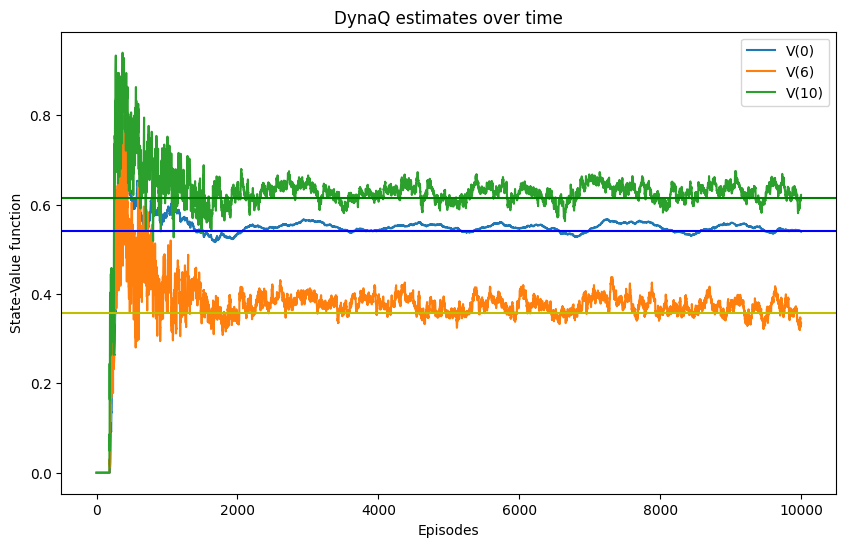

In [72]:
# YOUR CODE HERE

# Import matplotlib.pyplot as plt and plot the V_track_dq for each episode for states 0, 6 and 10
# draw a horizontal line for the optimal_V for states 0, 6 and 10

import matplotlib.pyplot as plt

legends = ['V(0)','V(6)','V(10)']

plt.figure(figsize=(10,6))

plt.plot(V_track_dq[:,[0,6,10]])

plt.axhline(y=optimal_V[0], color='b', linestyle='-')
plt.axhline(y=optimal_V[6], color='y', linestyle='-')
plt.axhline(y=optimal_V[10], color='g', linestyle='-')

plt.title('DynaQ estimates over time')
plt.ylabel('State-Value function')
plt.xlabel('Episodes')
plt.legend(legends)

plt.show()

4 - Implement the Trajectory Sampling algorithm and use it against the FL environment.

In [58]:
# YOUR CODE HERE

# Copy the trajectory_sampling function from the lecture notes and modify it in order to ask the environment the number
# of states and actions following the Gymnasium interface (.n), to call the step() function using 
# the Gymnasium interface (5 outputs), and extract the id of the starting state from the first 
# output of the reset() function.

def trajectory_sampling(env, gamma=1.0, init_alpha=0.5, min_alpha=0.01, init_epsilon=1.0, min_epsilon=0.1, decay_episodes=2000,
                        n_planning=3, n_episodes=2000):
            
    nS, nA = env.observation_space.n, env.action_space.n
    pi_track =[]
   
    Q = np.zeros((nS, nA), dtype=float)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=float)
    V_track = np.zeros((n_episodes, nS), dtype=float)
    
    T_count = np.zeros((nS, nA, nS), dtype=int)
    R_model = np.zeros((nS, nA, nS), dtype=float)
    T_track, R_track, planning_track = [], [], []
    
    alphas = decay_schedule(init_alpha, min_alpha, decay_episodes, n_episodes);
    epsilons = decay_schedule(init_epsilon, min_epsilon, decay_episodes, n_episodes)

    for e in range(n_episodes):
                   
        state, done = env.reset()[0], False

        while not done:
            action = select_action(state, Q, epsilons[e])
            next_state, reward, done, _, _ = env.step(action)
            
            T_count[state][action][next_state] += 1
            r_diff = reward - R_model[state][action][next_state]
            R_model[state][action][next_state] += (r_diff / T_count[state][action][next_state])

            td_target = reward + gamma * Q[next_state].max() * (not done)
            td_error = td_target - Q[state][action]
            Q[state][action] = Q[state][action] + alphas[e] * td_error
            
            backup_next_state = next_state

            for _ in range(n_planning):
                
                if Q.sum() == 0: 
                    break

                # select the action following the behavioral policy or from the greedy policy ì
                # select_action(state, Q, epsilons[e])
                action = Q[state].argmax()
                    
                # if we haven’t experienced the transition, 
                # planning would be a mess, so break out
                if not T_count[state][action].sum(): 
                    break

                # otherwise, get the probabilities of next_state and sample 
                # the model accordingly, as in DynaQ
                probs = T_count[state][action]/T_count[state][action].sum()
                next_state = np.random.choice(np.arange(nS), size=1, p=probs)[0]
                    
                # get the reward as prescribed by the reward-signal model, as in DynaQ
                reward = R_model[state][action][next_state]
                planning_track.append((state, action, reward, next_state))

                    
                # continue updating the Q-function as if with real experience, as in DynaQ
                td_target = reward + gamma * Q[next_state].max()
                td_error = td_target - Q[state][action]
                Q[state][action] = Q[state][action] + alphas[e] * td_error

                # we update the state variable before we loop and 
                # continue the planning steps
                state = next_state

            V = np.max(Q, axis=1)
            
            # outside the planning loop, we restore the state, 
            # and continue real interaction steps
            state = backup_next_state

        T_track.append(T_count.copy())
        R_track.append(R_model.copy())
        Q_track[e] = Q
        V_track[e] = V
        pi_track.append(np.argmax(Q, axis=1))

    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    
    return Q, V, pi, Q_track, V_track, pi_track, T_track, R_track, np.array(planning_track)

In [59]:
# YOUR CODE HERE

# Apply trajectory_sampling for 10.000 episodes ans gamma = 0.99

Q_ts, V_ts, pi_ts, Q_track_ts, V_track_ts, pi_track_ts, T_track_ts, R_track_ts, planning_ts = trajectory_sampling(frozen_lake, decay_episodes=2500, n_episodes=10000, gamma=0.99)

5 - Plot the state-value functions for states (0, 6, 10) for Trajectory Sampling and observe that there is more stability. 

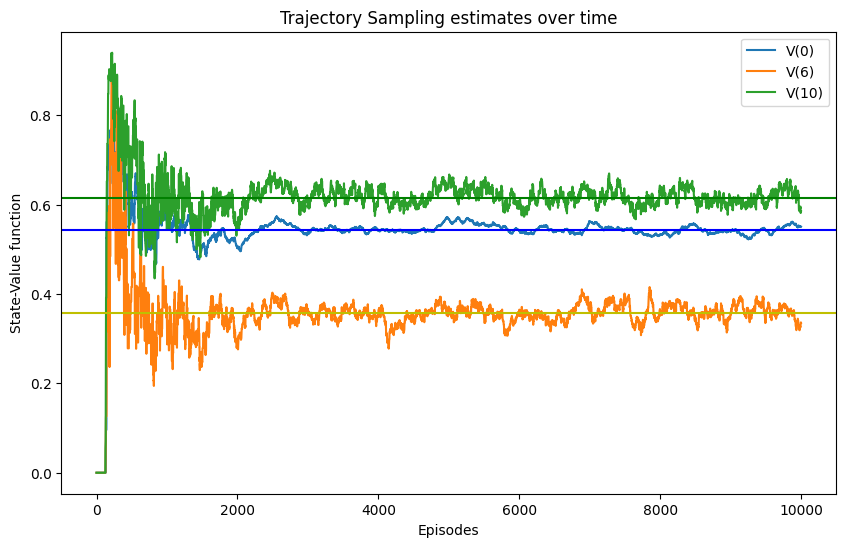

In [73]:
# YOUR CODE HERE

# Plot the V_track_ts for each episode for states 0, 6 and 10
# draw a horizontal line for the optimal_V for states 0, 6 and 10

plt.figure(figsize=(10,6))

plt.plot(V_track_ts[:,[0,6,10]])

plt.axhline(y=optimal_V[0], color='b', linestyle='-')
plt.axhline(y=optimal_V[6], color='y', linestyle='-')
plt.axhline(y=optimal_V[10], color='g', linestyle='-')

plt.title('Trajectory Sampling estimates over time')
plt.ylabel('State-Value function')
plt.xlabel('Episodes')
plt.legend(legends)

plt.show()

6 - compare all methods (also SARSA(lambda) and Q(lambda)) plotting the mean absolute error and observe that the model-based methods also bring the error down close to zero. However, shortly after 2,000 episodes, both model-based and Q(lambda) methods are much the same. SARSA(lambda) methods are also slow to optimal here.

In [61]:
# YOUR CODE HERE

# Copy the SARSA(lambda) function from the previous lab

def sarsa_lambda(env, gamma=1.0, init_alpha=0.5, min_alpha=0.01, init_epsilon=1.0, min_epsilon=0.1, decay_episodes=350,
                lambda_=0.5, replacing_traces=True, n_episodes=2000):
    nS, nA = env.observation_space.n, env.action_space.n
    
    pi_track = []
    Q = np.zeros((nS, nA), dtype=float)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=float)
    V_track = np.zeros((n_episodes, nS), dtype=float)
    
    # eligibility traces
    E = np.zeros((nS, nA), dtype=float)

    alphas = decay_schedule(init_alpha, min_alpha, decay_episodes, n_episodes)
    epsilons = decay_schedule(init_epsilon, min_epsilon, decay_episodes, n_episodes)
    
    for e in range(n_episodes):
        # every new episode, set the eligibility of every state to zero
        E.fill(0)

        # select the action of the initial state
        state, done = env.reset(), False
        state = state[0]
        action = select_action(state, Q, epsilons[e])
        
        # interaction loop
        while not done:
            
            # step the environment and get the experience
            next_state, reward, done, _, _ = env.step(action)
            
            # obtain the action for the next step
            next_action = select_action(next_state, Q, epsilons[e])

            # calculate the td_target using that next state-action pair
            td_target = reward + gamma * Q[next_state][next_action]
            
            # calculate the td_error 
            td_error = td_target - Q[state][action]
            
            # increment the state-action pair trace, 
            # and clip it to 1 if it’s a replacing trace
            if replacing_traces: 
                E[state].fill(0)
            E[state][action] = E[state][action] + 1
            if replacing_traces: 
                E.clip(0, 1, out=E)
            
            # apply the TD error to all eligible state-action pairs at once
            # even though we’re using the entire Q-table, E will be mostly 0, 
            # and greater than zero for eligible pairs
            Q = Q + alphas[e] * td_error * E
            V = np.max(Q, axis=1)
            
            # decay the eligibility matrix
            E = gamma * lambda_ * E 
            
            # update state and action for the next step
            state, action = next_state, next_action

        # save the Q-function and greedy policy for analysis    
        Q_track[e] = Q
        V_track[e] = V
        pi_track.append(np.argmax(Q, axis=1))

    # calculate the V-function and its greedy policy
    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    
    return Q, V, pi, Q_track, V_track, pi_track


In [62]:
# YOUR CODE HERE

# Apply SARSA(lambda) for 10.000 episodes ans gamma = 0.99

Q_sarsa_lambda, V_sarsa_lambda, pi_sarsa_lambda, Q_track_sarsa_lambda, V_track_sarsa_lambda, pi_track_sarsa_lambda = sarsa_lambda(frozen_lake, decay_episodes=2500, n_episodes=10000, gamma=0.99)

In [63]:
# YOUR CODE HERE

# Copy the Q(lambda) function from the previous lab

def q_lambda(env, gamma=1.0, init_alpha=0.5, min_alpha=0.01, init_epsilon=1.0, min_epsilon=0.1, decay_episodes=350,
             lambda_=0.5, replacing_traces=True, n_episodes=2000):
    
    nS, nA = env.observation_space.n, env.action_space.n
    
    pi_track = []
    Q = np.zeros((nS, nA), dtype=float)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=float)
    V_track = np.zeros((n_episodes, nS), dtype=float)
        
    E = np.zeros((nS, nA), dtype=float)
    
    alphas = decay_schedule(init_alpha, min_alpha, decay_episodes, n_episodes)
    epsilons = decay_schedule(init_epsilon, min_epsilon, decay_episodes, n_episodes)
    
    for e in range(n_episodes):
        E.fill(0)
        
        state, done = env.reset(), False
        state = state[0]
        
        # notice: we are preselecting the action as in SARSA, (we didn’t do that in Q-learning) 
        # this is because we need to check whether our next action is greedy for deciding
        # to decay the eligibility trace
        action = select_action(state, Q, epsilons[e])
        
        while not done:
            
            next_state, reward, done, _, _ = env.step(action)
            
            # select the next_action SARSA-style
            next_action = select_action(next_state, Q, epsilons[e])
            
            # use it to verify that the action on the next step 
            # will still come from the greedy policy
            next_action_is_greedy = Q[next_state][next_action] == Q[next_state].max()

            # still calculate the TD target as in regular Q-learning, using the max
            td_target = reward + gamma * Q[next_state].max()
            
            # and use the TD target to calculate the TD error
            td_error = td_target - Q[state][action]
            
            if replacing_traces: 
                E[state].fill(0)
            E[state][action] = E[state][action] + 1
            if replacing_traces: 
                E.clip(0, 1, out=E)
            
            # as before, we multiply the entire eligibility trace matrix 
            # by the error and the learning rate corresponding to episode e, 
            Q = Q + alphas[e] * td_error * E
            V = np.max(Q, axis=1)
            
            # if the action we’ll take on the next state (which we already selected) is a greedy action, 
            # then we decay the eligibility matrix as usual, otherwise, we must reset 
            # the eligibility matrix to zero because we’ll no longer be learning about the greedy policy
            if next_action_is_greedy:
                E = gamma * lambda_ * E
            else:
                E.fill(0)

            state, action = next_state, next_action

        Q_track[e] = Q
        V_track[e] = V
        pi_track.append(np.argmax(Q, axis=1))

    V = np.max(Q, axis=1)        
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    return Q, V, pi, Q_track, V_track, pi_track

In [64]:
# YOUR CODE HERE

# Apply Q(lambda) for 10.000 episodes ans gamma = 0.99

Q_q_lambda, V_q_lambda, pi_q_lambda, Q_track_q_lambda, V_track_q_lambda, pi_track_q_lambda = q_lambda(frozen_lake, decay_episodes=2500, n_episodes=10000, gamma=0.99)

In [65]:
# YOUR CODE HERE

# Copy the moving average function from the previous lab

def moving_average(a, n=100) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

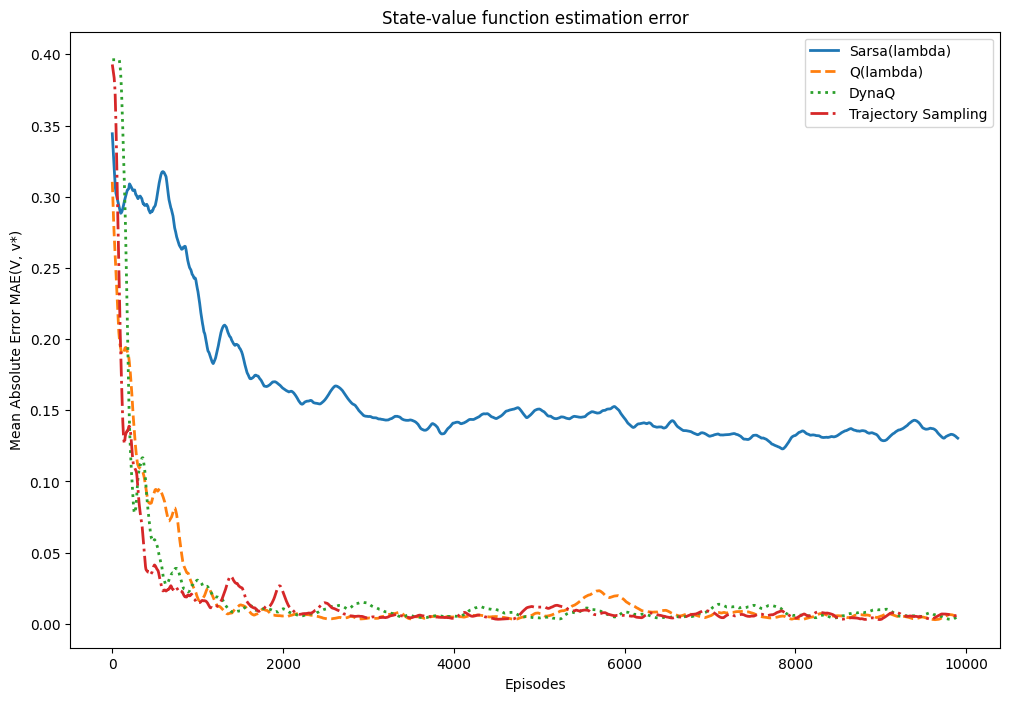

In [74]:
# YOUR CODE HERE

# copy the plotting of the moving average of the absolute error 
# from the previous lab

plt.figure(figsize=(12,8))

plt.plot(moving_average(np.mean(np.abs(V_track_sarsa_lambda - optimal_V), axis=1)), '-', linewidth=2, label='Sarsa(lambda)')
plt.plot(moving_average(np.mean(np.abs(V_track_q_lambda - optimal_V), axis=1)), '--', linewidth=2, label='Q(lambda)')
plt.plot(moving_average(np.mean(np.abs(V_track_dq - optimal_V), axis=1)), ':', linewidth=2, label='DynaQ')
plt.plot(moving_average(np.mean(np.abs(V_track_ts - optimal_V), axis=1)), '-.', linewidth=2, label='Trajectory Sampling')
plt.legend(loc=1, ncol=1)

plt.title('State-value function estimation error')
plt.xlabel('Episodes')
plt.ylabel('Mean Absolute Error MAE(V, v*)')

plt.show()